In [2]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys

## Pair sound files and annotation
# Combine the two cells to avoid overlap!!!

In [16]:
soundfiles = glob.glob('trainfiles/**/*.sph', recursive = True)
#annofiles = glob.glob('./**/*.txt', recursive = True) + glob.glob('./**/*.sgml', recursive = True)
data = {}
for soundfile in soundfiles:
    name = soundfile.split('/')[-1].split('.')[0]
    annofile = list(glob.glob('trainfiles/**/'+name+'.txt', recursive = True)) + list(glob.glob('trainfiles/**/'+name+'.sgml', recursive = True))
    annofile = annofile[0]
    data[soundfile] = annofile
start_load = time.time()
sph = SPHFile(soundfiles[200])
junk, sr = sph.content, sph.format['sample_rate']
print(time.time()-start_load)
data

0.061274051666259766


{'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960521_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960521_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960522_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960522_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960523_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960523_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960524_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960524_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960528_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960528_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960530_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960530_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960604_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960604_.txt',
 'trainfiles/LDC97S44/H4E96_01/h4eng_sp/a960605_.sph': 'trainfiles/LDC97T22/hub4_eng_train_trans/aABC_NLI/a960605_.txt',
 'trainfiles/LDC97S44/H4E96_01/h

-79.78867

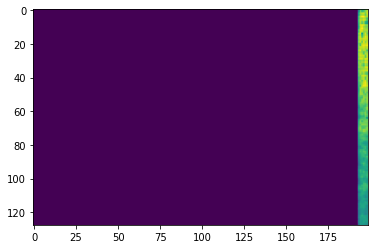

In [17]:
S = librosa.feature.melspectrogram(junk[:2*sr]/(2**15), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
plt.imshow(S_dB)
S_dB.min()

## Figure out gender of each speaker

In [18]:
# gender = {}
# for annofile in data.values():
#     doc = parse(annofile)
#     for tag in doc.getroot().iter():
#         if tag.tag in ['segment', 'turn']:
#             if 'spkrtype' in tag.attrib:
#                 gender[tag.attrib['speaker']] = tag.attrib['spkrtype']
gender = np.load('gender.npy', allow_pickle = True).reshape(1)[0]

## Pydub Silence Example

In [19]:
seg = audiosegment.from_numpy_array(junk, sr)
silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
print(sum([b-a for [a, b] in silences]))
print(len(junk))

11903204
30720000


## Annotation Example

In [20]:
annofile = data[soundfiles[np.random.randint(len(soundfiles))]]
doc = parse(annofile)
last_end = 0
for tag in doc.getroot().iter():
    if tag.tag == 'segment': # segment for txt files, turn for sgml files
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['s_time'])<last_end:
            print('interrupt', last_end, tag.attrib['s_time'])
        last_end = float(tag.attrib['e_time'])
    elif tag.tag == 'turn':
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['starttime'])<last_end:
            print('interrupt', last_end, tag.attrib['starttime'])
        last_end = float(tag.attrib['endtime'])
tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
segment_idx = np.random.randint(0, len(tags))
example_tag = tags[segment_idx]
if example_tag.tag == 'segment':
    start, end = example_tag.attrib['s_time'], example_tag.attrib['e_time']
else:
    start, end = example_tag.attrib['starttime'], example_tag.attrib['endtime']
print(start, end, example_tag.text_content(), example_tag.attrib['speaker'])
end = int(float(end)*sr)
start = max(end-2*sr, int(float(start)*sr))

452.403 458.584 
it certainly is disturbing that people are not getting the um

{lipsmack} the treatment that we recommend for them
 c960521_M_US_015


# Ending Segments

In [21]:
# emptiness = []
end_df = pd.DataFrame()
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j + 1 < len(tags) and float(tags[j+1].attrib['s_time']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j + 1 < len(tags) and float(tags[j+1].attrib['starttime']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        start = end-2*sr
        
        
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[-1][1] == 2*sr: # if silence at end, remove that silence
                end = end - 2*sr + silences[-1][0] # readjust silence end
                if segment.tag == 'segment':
                    start = int(float(segment.attrib['s_time'])*sr)
                else:
                    start = int(float(segment.attrib['starttime'])*sr)
                if start >= end - 2*sr: # if segment too short
                    continue
                start = end - 2*sr
        
        
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out start of first silence, if any
        #    print(silences[0][0])
        length_silence = sum([b-a for [a, b] in silences])
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'trainfiles/end_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            end_df = end_df.append(row, ignore_index = True)
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
end_df.to_csv('trainfiles/end.csv', index = False)
end_df

,end,file,filename,segment,silence_ratio,speaker,start
0,129520.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/end_segments/d960531aseg0.npy,0.0,0.110,Martin_Savage,97520.0
1,379952.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/end_segments/d960531aseg2.npy,2.0,0.000,Andrea_Arsenault,347952.0
2,760176.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/end_segments/d960531aseg3.npy,3.0,0.000,Veronica_Petrosa,728176.0
3,1131680.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/end_segments/d960531aseg4.npy,4.0,0.000,d960531a_F_NUS_009,1099680.0
4,2679904.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/end_segments/d960531aseg5.npy,5.0,0.195,Brent_Sadler,2647904.0
...,...,...,...,...,...,...,...
20794,22934160.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/end_segments/em970928seg74.npy,74.0,0.295,spkr_16,22902160.0
20795,23303568.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/end_segments/em970928seg78.npy,78.0,0.095,David_Brinkley,23271568.0
20796,23416224.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/end_segments/em970928seg79.npy,79.0,0.180,Frank_Sesno,23384224.0
20797,23520064.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/end_segments/em970928seg80.npy,80.0,0.000,David_Brinkley,23488064.0


## Starting segments

In [23]:
start_df = pd.DataFrame() # different
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j > 0 and float(tags[j-1].attrib['e_time']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j > 0 and float(tags[j-1].attrib['endtime']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        end = start + 2*sr   # different
        

        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[0][0] == 0: # if silence at start, remove that silence # different
                start = start + silences[0][1] - int(0.1*sr) # readjust silence start # different, include attack
                if segment.tag == 'segment':
                    end = int(float(segment.attrib['e_time'])*sr) # different
                else:
                    end = int(float(segment.attrib['endtime'])*sr) # different
                if start >= end - 2*sr: # if segment too short
                    continue
                end = start + 2*sr # different
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out end of first silence, if any
        #    print(silences[0][1]) # different
        length_silence = sum([b-a for [a, b] in silences])
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'trainfiles/start_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            start_df = start_df.append(row, ignore_index = True) # different
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
start_df.to_csv('trainfiles/start.csv', index = False)
start_df

,end,file,filename,segment,silence_ratio,speaker,start
0,46112.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/start_segments/d960531aseg0.npy,0.0,0.000,Martin_Savage,14112.0
1,194016.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/start_segments/d960531aseg2.npy,2.0,0.165,Andrea_Arsenault,162016.0
2,432000.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/start_segments/d960531aseg3.npy,3.0,0.100,Veronica_Petrosa,400000.0
3,811152.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/start_segments/d960531aseg4.npy,4.0,0.000,d960531a_F_NUS_009,779152.0
4,1207968.0,trainfiles/LDC97S44/H4E96_07/h4eng_sp/d960531a...,trainfiles/start_segments/d960531aseg5.npy,5.0,0.050,Brent_Sadler,1175968.0
...,...,...,...,...,...,...,...
22836,23457184.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/start_segments/em970928seg80.npy,80.0,0.050,David_Brinkley,23425184.0
22837,23622800.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/start_segments/em970928seg82.npy,82.0,0.295,David_Brinkley,23590800.0
22838,23791488.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/start_segments/em970928seg84.npy,84.0,0.255,Frank_Sesno,23759488.0
22839,24197760.0,trainfiles/LDC98S71/H4E97_08/em970928.sph,trainfiles/start_segments/em970928seg87.npy,87.0,0.290,Jeanne_Meserve,24165760.0


In [25]:
from bs4 import BeautifulSoup
total_segs = 0
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    try:
        with open(annofile) as file:
            soup = BeautifulSoup(file,'html.parser')
        print(annofile, len(soup.find_all(['segment', 'turn'])))
        total_segs+=len(soup.find_all(['segment', 'turn']))
        
    except:
        print('broken file ', annofile)
    if len(soup.find_all(['segment', 'turn'])) < 10:
        print(soup.find_all(['segment', 'turn']))
        print('error parsing ', annofile)
        break
total_segs

trainfiles/LDC97T22/hub4_eng_train_trans/dCNN_EED/d960531a.txt 97
trainfiles/LDC97T22/hub4_eng_train_trans/dCNN_EED/d960604b.txt 69
trainfiles/LDC97T22/hub4_eng_train_trans/dCNN_EED/d960531b.txt 92
trainfiles/LDC97T22/hub4_eng_train_trans/dCNN_EED/d960604a.txt 92
trainfiles/LDC97T22/hub4_eng_train_trans/gCNN_PRN/g960523_.txt 92
trainfiles/LDC97T22/hub4_eng_train_trans/hCNN_TWT/h960516_.txt 157
trainfiles/LDC97T22/hub4_eng_train_trans/gCNN_PRN/g960529_.txt 70
trainfiles/LDC97T22/hub4_eng_train_trans/gCNN_PRN/g960611_.txt 89
trainfiles/LDC97T22/hub4_eng_train_trans/gCNN_PRN/g960607_.txt 88
trainfiles/LDC97T22/hub4_eng_train_trans/hCNN_TWT/h960517_.txt 150
trainfiles/LDC97T22/hub4_eng_train_trans/gCNN_PRN/g960524_.txt 75
trainfiles/LDC97T22/hub4_eng_train_trans/jNPR_ATC/j960531d.txt 78
trainfiles/LDC97T22/hub4_eng_train_trans/jNPR_ATC/j960607c.txt 79
trainfiles/LDC97T22/hub4_eng_train_trans/jNPR_ATC/j960613c.txt 82
trainfiles/LDC97T22/hub4_eng_train_trans/jNPR_ATC/j960531b.txt 129
trainfi

KeyboardInterrupt: 

In [ ]:
spkrfile = 'trainfiles/LDC97T22/hub4_eng_train_trans/spkrlist.sgml'
spkrlist = []
with open(spkrfile) as file:
    for line in file:
        soup = BeautifulSoup(line, 'html.parser')
        if soup.speaker != None:
            #print(soup.speaker)
            spkrlist.append(soup.speaker['name'])
spkrlist

In [ ]:
spkrlist = Counter(spkrlist)
print([speaker for speaker in spkrlist.keys() if spkrlist[speaker]>1])

# Train&Validate Split, figure out speakers

In [27]:
start_df = pd.read_csv('trainfiles/start.csv')
end_df = pd.read_csv('trainfiles/end.csv')
segments_df = start_df.append(end_df, ignore_index = True)
speaker_count = Counter(list(segments_df['speaker']))
speakers = list(speaker_count)
#speakers = [x for x in speaker_count if speaker_count[x] >= 35] # for each speaker, we generate a 54*54 pairs and remove those with >1s overlap
# speakers = [x for x in speakers if x not in ['ABC_NLI_Announcer', 'CSP_WAJ_Susan', 'Susan', 
#                                              'i960604_F_US_001', 'i960604_F_US_026', 'i960711p_anchor2',
#                                              'b960530_F_US_007', 'b960530_M_US_008', 'i960604_M_US_027',
#                                              'i960711p_johndoe003']]
# speakers = [x for x in speakers if x[0:4] not in ['male', 'spkr', 'fema']]
speakers.sort()
print(len(speakers),'speakers')
start_df = start_df.sample(frac=1).reset_index(drop=True)
end_df = end_df.sample(frac=1).reset_index(drop=True)

3839 speakers


In [35]:
speakers[2850:]

['e960521b_M_US_013',
 'e960521b_M_US_014',
 'e960521b_M_US_015',
 'e960521b_M_US_017',
 'e960521b_M_US_020',
 'e960521b_M_US_021',
 'e960521b_M_US_022',
 'e960521b_M_US_023',
 'e960522a_F_US_007',
 'e960522a_F_US_011',
 'e960522a_M_US_001',
 'e960522a_M_US_002',
 'e960522a_M_US_003',
 'e960522a_M_US_005',
 'e960522a_M_US_008',
 'e960522a_M_US_009',
 'e960522a_M_US_010',
 'e960522a_M_US_012',
 'e960522a_M_US_013',
 'e960522b_F_US_001',
 'e960522b_F_US_003',
 'e960522b_F_US_004',
 'e960522b_F_US_005',
 'e960522b_M_US_006',
 'e960522b_M_US_007',
 'e960522b_M_US_010',
 'e960522b_M_US_011',
 'e960522b_M_US_012',
 'e960522b_M_US_013',
 'e960522b_M_US_014',
 'f960531_F_NUS_005',
 'f960531_F_US_007',
 'f960531_F_US_008',
 'f960531_F_US_018',
 'f960531_F_US_021',
 'f960531_M_NUS_002',
 'f960531_M_NUS_003',
 'f960531_M_NUS_004',
 'f960531_M_NUS_006',
 'f960531_M_US_001',
 'f960531_M_US_009',
 'f960531_M_US_010',
 'f960531_M_US_011',
 'f960531_M_US_012',
 'f960531_M_US_013',
 'f960531_M_US_014',

In [ ]:
# count = 0
# for speaker in speakers:
#     if speaker not in gender:
#         print(speaker, end = '  ')
#         key = input()
#         while key not in ['1', '2']:
#             key = input()
#         if key == '1':
#             print('male')
#             gender[speaker] = 'male'
#         else:
#             print('female')
#             gender[speaker] = 'female'
#         np.save('gender.npy', gender) 

In [ ]:
def calculate_overlap(row1, row2):
    if row1['file'] != row2['file']: # can only overlap if in same file
        return 0
    if row1['end']<row2['start'] or row1['start']>row2['end']:
        return 0
    if row1['start']<row2['start']:
        return row1['end']-row2['start']
    return row2['end']-row1['start']
# overlap_count = 0
# for _, row1 in segments_df.iterrows():
#     #print(row1)
#     candidates = segments_df[segments_df['file'] == row1['file']]
#     candidates = candidates[candidates['speaker'] == row1['speaker']]
#     for _, row2 in candidates.iterrows():
#         if calculate_overlap(row1, row2)>0:
#             overlap_count+=1
#             #print(row2)
#     overlap_count-=1 # every segment overlaps with itself
# overlap_count

# Train

## Pool start/end segments

In [ ]:
# sample training data
start_df = start_df[:int(len(start_df)*0.9)]
end_df = end_df[:int(len(end_df)*0.9)]

segments_df = start_df.append(end_df, ignore_index = True)
segments_by_speaker = {}
# for faster fetching of triplets negative speaker
for speaker in speakers:
    segments_by_speaker[speaker] = segments_df[segments_df['speaker'] == speaker]
# for faster fetching of pairs negative speaker
start_segments_by_speaker = {}
for speaker in speakers:
    start_segments_by_speaker[speaker] = start_df[start_df['speaker'] == speaker]
for speaker in speakers:
    print(speaker)

## Make triplets

In [ ]:
triplets = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = segments_df[segments_df['speaker'] == anchor_speaker]
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments),35)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(anchor_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(anchor_segments),35)):
            positive_segment = anchor_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            row = {'anchor_speaker': anchor_speaker, 'anchor_file': anchor_segment['filename'], 
                   'positive_file': positive_segment['filename'], 'negative_speaker':negative_speaker,
                   'negative_file': negative_segment['filename']}
            triplets.append(row)
triplets = pd.DataFrame(triplets)

triplets.to_csv('trainfiles/train-triplets.csv')
triplets

## Make pairs

In [ ]:
pairs = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = end_df[end_df['speaker'] == anchor_speaker] # at end of segment
    positive_segments = start_df[start_df['speaker'] == anchor_speaker] # at start of segment
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments), 50)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(positive_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(positive_segments), 50)):
            # positive examples
            positive_segment = positive_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            # swap 1st 2nd randomly
            pos_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
                       'second_speaker': anchor_speaker, 'second_file': positive_segment['filename'],
                       'label': 0} # no speaker change
      
            # negative examples
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = start_segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            neg_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
               'second_speaker': negative_speaker, 'second_file': negative_segment['filename'],
               'label': 1} # has speaker change
            pairs.append(pos_row)
            pairs.append(neg_row)
pairs = pd.DataFrame(pairs)
pairs.to_csv('trainfiles/train-pairs.csv')

# Validate

## Pool start/end segments

In [ ]:
# sample val data
start_df = start_df[int(len(start_df)*0.9):]
end_df = end_df[int(len(end_df)*0.9):]

segments_df = start_df.append(end_df, ignore_index = True)
segments_by_speaker = {}
# for faster fetching of triplets negative speaker
for speaker in speakers:
    segments_by_speaker[speaker] = segments_df[segments_df['speaker'] == speaker]
# for faster fetching of pairs negative speaker
start_segments_by_speaker = {}
for speaker in speakers:
    start_segments_by_speaker[speaker] = start_df[start_df['speaker'] == speaker]
for speaker in speakers:
    print(speaker)

## Make triplets

In [ ]:
triplets = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = segments_df[segments_df['speaker'] == anchor_speaker]
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments),35)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(anchor_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(anchor_segments),35)):
            positive_segment = anchor_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            while len(start_segments_by_speaker[negative_speaker] == 0): #if we dropped someone totally
                negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            row = {'anchor_speaker': anchor_speaker, 'anchor_file': anchor_segment['filename'], 
                   'positive_file': positive_segment['filename'], 'negative_speaker':negative_speaker,
                   'negative_file': negative_segment['filename']}
            triplets.append(row)
triplets = pd.DataFrame(triplets)

triplets.to_csv('trainfiles/val-triplets.csv')
triplets

## Make pairs

In [ ]:
pairs = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = end_df[end_df['speaker'] == anchor_speaker] # at end of segment
    positive_segments = start_df[start_df['speaker'] == anchor_speaker] # at start of segment
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments), 50)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(positive_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(positive_segments), 50)):
            # positive examples
            positive_segment = positive_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            # swap 1st 2nd randomly
            pos_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
                       'second_speaker': anchor_speaker, 'second_file': positive_segment['filename'],
                       'label': 0} # no speaker change
      
            # negative examples
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            while len(start_segments_by_speaker[negative_speaker]) == 0: #if we dropped someone totally
                negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = start_segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            neg_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
               'second_speaker': negative_speaker, 'second_file': negative_segment['filename'],
               'label': 1} # has speaker change
            pairs.append(pos_row)
            pairs.append(neg_row)
pairs = pd.DataFrame(pairs)
pairs.to_csv('trainfiles/val-pairs.csv')
pairs